In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [10]:
#!pip3 install yfinance

In [7]:
import yfinance as yf

In [19]:
amzn_historical = amzn.history(start="2010-01-01", 
                               end="2021-07-18", 
                               interval="1d")
amzn_historical.head(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2010-01-04,136.250000,136.610001,133.139999,133.899994,7599900,0,0
2010-01-05,133.429993,135.479996,131.809998,134.690002,8851900,0,0
2010-01-06,134.600006,134.729996,131.649994,132.250000,7178800,0,0
2010-01-07,132.009995,132.320007,128.800003,130.000000,11030200,0,0
2010-01-08,130.559998,133.679993,129.029999,133.520004,9830500,0,0
2010-01-11,132.619995,132.800003,129.210007,130.309998,8779400,0,0
2010-01-12,128.990005,129.820007,126.550003,127.349998,9096300,0,0
2010-01-13,127.900002,129.710007,125.750000,129.110001,10723200,0,0
2010-01-14,129.139999,130.380005,126.400002,127.349998,9774900,0,0


In [20]:
amzn.info

{'zip': '98109-5210',
 'sector': 'Consumer Cyclical',
 'fullTimeEmployees': 1271000,
 'longBusinessSummary': 'Amazon.com, Inc. engages in the retail sale of consumer products and subscriptions in North America and internationally. The company operates through three segments: North America, International, and Amazon Web Services (AWS). It sells merchandise and content purchased for resale from third-party sellers through physical and online stores. The company also manufactures and sells electronic devices, including Kindle, Fire tablets, Fire TVs, Rings, and Echo and other devices; provides Kindle Direct Publishing, an online service that allows independent authors and publishers to make their books available in the Kindle Store; and develops and produces media content. In addition, it offers programs that enable sellers to sell their products on its websites, as well as its stores; and programs that allow authors, musicians, filmmakers, skill and app developers, and others to publish 

In [21]:
oil= yf.Ticker("cl=f")
oil_historical = oil.history(start='2010-01-01',
                             end='2021-07-18',
                             interval='1d')
oil_historical.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2010-01-04,79.629997,81.680000,79.629997,81.510002,263542,0,0
2010-01-05,81.629997,82.000000,80.949997,81.769997,258887,0,0
2010-01-06,81.430000,83.519997,80.849998,83.180000,370059,0,0
2010-01-07,83.199997,83.360001,82.260002,82.660004,246632,0,0
2010-01-08,82.650002,83.470001,81.800003,82.750000,310377,0,0


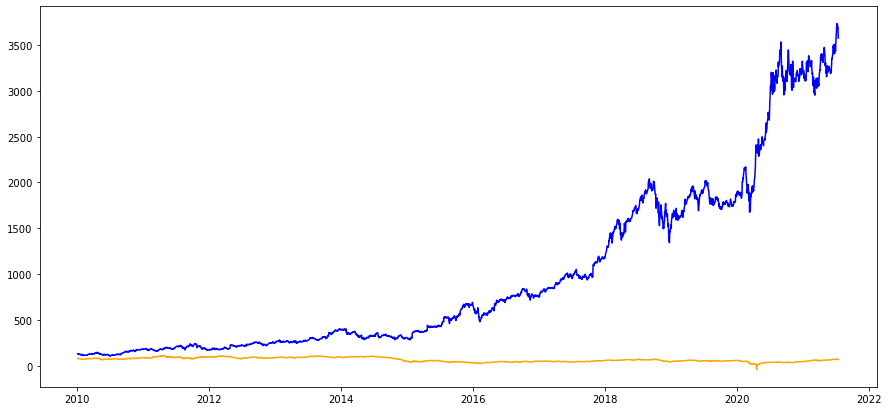

In [25]:
plt.figure(figsize=(15,7))
plt.plot(amzn_historical.Close, color='blue')
plt.plot(oil_historical.Close, color='orange');

In [26]:
amzn_returns = 100 * amzn_historical.Close.pct_change().dropna()
oil_returns = 100* oil_historical.Close.pct_change().dropna()

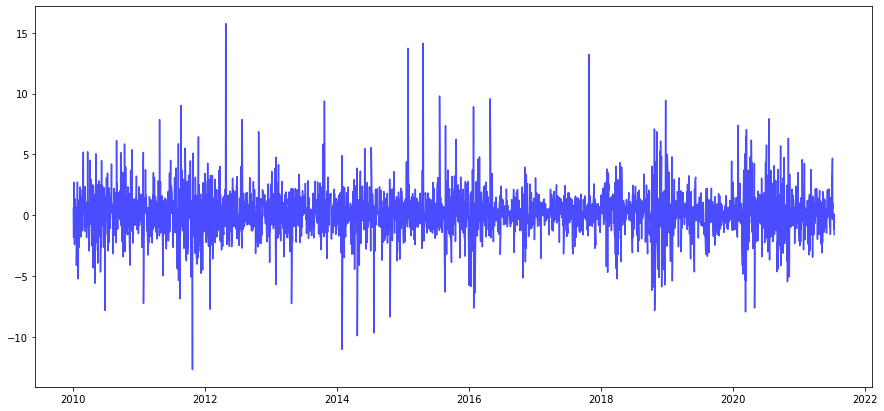

In [30]:
plt.figure(figsize=(15,7))
plt.plot(amzn_returns, color='blue', alpha=0.7);
# plt.plot(oil_returns, color='orange', alpha=0.7);

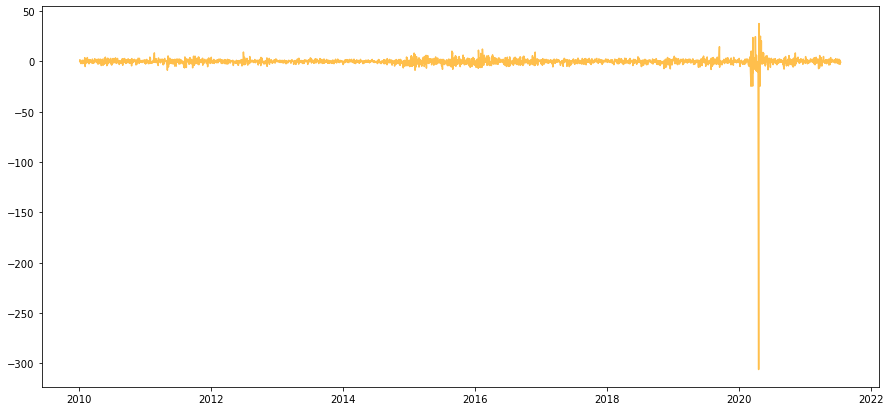

In [31]:
plt.figure(figsize=(15,7))
plt.plot(oil_returns, color='orange', alpha=0.7);

In [32]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

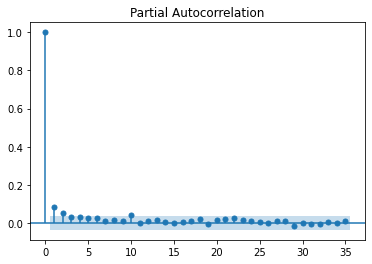

In [33]:
plot_pacf(amzn_returns**2)
plt.show();

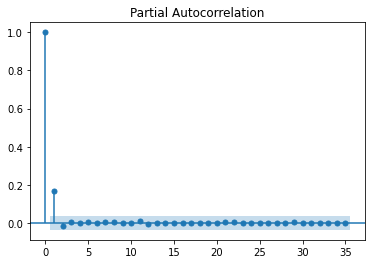

In [34]:
plot_pacf(oil_returns**2)
plt.show();

In [37]:
from datetime import datetime, date

In [38]:
tickers = ['aapl', 'amzn', 'cl=f', 'tsla', 'btc-usd']

start = datetime(2010, 1, 1)
end = datetime.today()

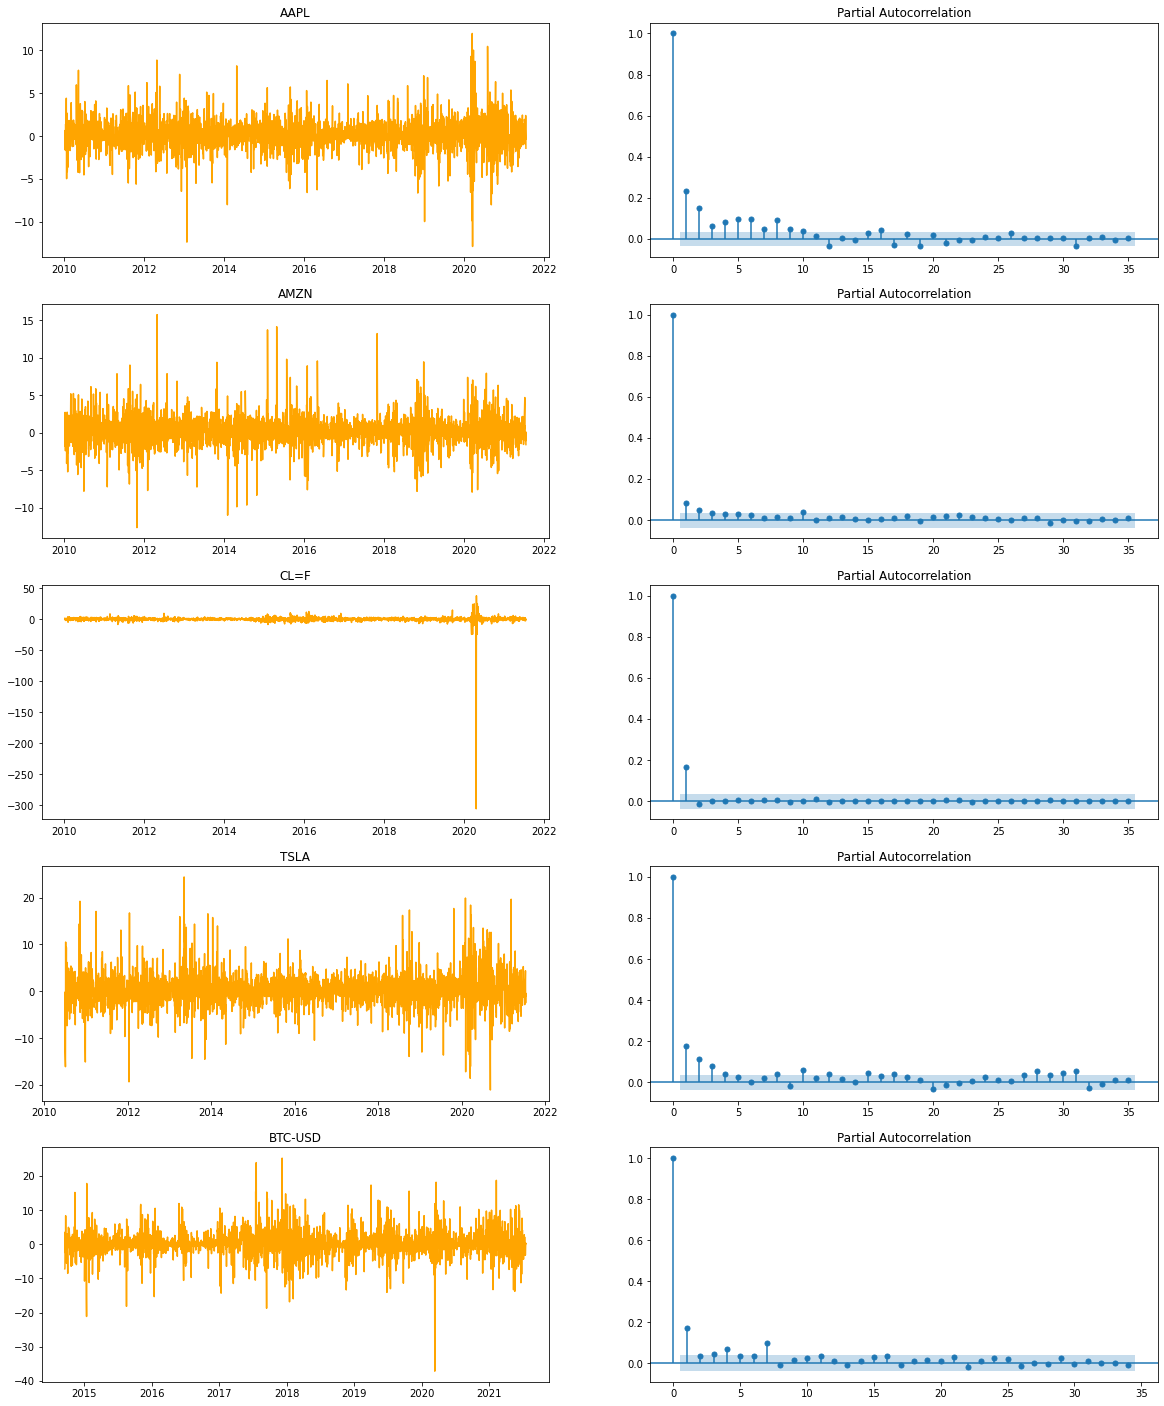

In [41]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20,25))

for i, ticker in enumerate(tickers):
    tckr = yf.Ticker(ticker)
    historical = tckr.history(start=start, 
                              end=end, 
                              interval="1d")
    
    returns = 100 * historical.Close.pct_change().dropna()
    axes[i][0].plot(returns, color='orange')
    axes[i][0].set_title(ticker.upper())
    plot_pacf(returns**2, ax=axes[i][1])
    
plt.show();

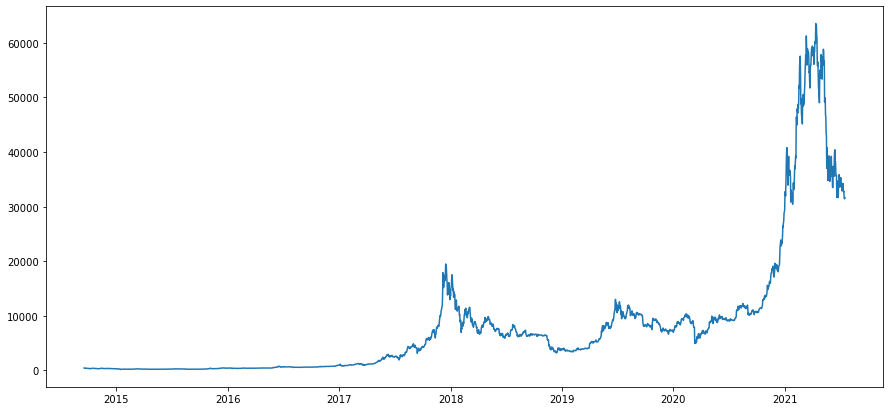

In [43]:
btcusd = yf.Ticker('btc-usd')
btcusd_historical = btcusd.history(start=start, 
                                   end=end, 
                                   interval="1d")

plt.figure(figsize=(15,7))
plt.plot(btcusd_historical.Close);